# Driver Behavior Dataset

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def get_event(seconds_passed, groundTruth):
    for _, row in groundTruth.iterrows():
        if row[' inicio'] <= seconds_passed <= row[' fim']:
            return row['evento']
    return None

In [4]:
def getGroundTruth(df, groundTruth_orig):
    df['seconds_passed'] = (df['uptimeNanos'] - df['uptimeNanos'].iloc[0]) / 1e9 # Converting timestamp to seconds passed
    df['evento'] = df['seconds_passed'].apply(lambda x: get_event(x, groundTruth_orig)) # Getting the event for each row based on seconds passed
    return df


In [65]:
def getData(driver):
    accLinear_orig = pd.read_csv(f'data/{driver}/aceleracaoLinear_terra.csv')
    acelerometro_orig = pd.read_csv(f'data/{driver}/acelerometro_terra.csv')
    giroscopio_orig = pd.read_csv(f'data/{driver}/giroscopio_terra.csv')
    groundTruth_orig = pd.read_csv(f'data/{driver}/groundTruth.csv')

    # Renaming columns to avoid conflicts
    accLinear = accLinear_orig.rename(columns={'x': 'x_accLinear', 'y': 'y_accLinear', 'z': 'z_accLinear'}, inplace=False) 
    acelerometro = acelerometro_orig.rename(columns={'x': 'x_acelerometro', 'y': 'y_acelerometro', 'z': 'z_acelerometro'}, inplace=False) 
    giroscopio = giroscopio_orig.rename(columns={'x': 'x_giroscopio', 'y': 'y_giroscopio', 'z': 'z_giroscopio'}, inplace=False)

    # Merging all dataframes
    df = pd.concat([accLinear, acelerometro, giroscopio], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]

    # Converting timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M:%S')
    # Getting the event for each row based on seconds passed
    df = getGroundTruth(df, groundTruth_orig)

    # Changing Nones to 'sem_evento'
    df['evento'] = df['evento'].fillna('sem_evento')

    return df

In [66]:
df_16 = getData(16)
df_17 = getData(17)
df_20 = getData(20)
df_21 = getData(21)

Plotting different sensors to see the difference

In [7]:
def plot_sensor_data(data, sensor=None, figsize=(10, 4), begin=None, end=None):
    if begin is not None:
        data = data[data['seconds_passed'] >= begin]
        if end < begin:
            raise ValueError('End must be greater than begin')

    if end is not None:
        data = data[data['seconds_passed'] <= end]

    if sensor is None:
        sensor = ['acelerometro', 'accLinear', 'giroscopio']
    
    plt.figure(figsize=figsize)
    plt.plot(data['seconds_passed'], data[f'x_{sensor}'], label=f'x_{sensor}')
    plt.plot(data['seconds_passed'], data[f'y_{sensor}'], label=f'y_{sensor}')
    plt.plot(data['seconds_passed'], data[f'z_{sensor}'], label=f'z_{sensor}')
    
    # Highlight regions where 'evento' is not None
    for i in range(len(data) - 1):
        if data['evento'].iloc[i] is not None:
            plt.axvspan(data['seconds_passed'].iloc[i], data['seconds_passed'].iloc[i + 1], alpha=0.3, edgecolor='none')
            if i == 0 or data['evento'].iloc[i] != data['evento'].iloc[i - 1]:
                plt.text((data['seconds_passed'].iloc[i] + data['seconds_passed'].iloc[i + 1]) / 2, 
                         max(data[f'x_{sensor}'].max(), data[f'y_{sensor}'].max(), data[f'z_{sensor}'].max()), 
                         data['evento'].iloc[i], 
                         horizontalalignment='left', 
                         verticalalignment='top', 
                         fontsize=12, 
                         color='black', 
                         rotation=0)

    plt.xlabel('Uptime (seconds)')
    plt.ylabel(sensor.capitalize())
    plt.legend()
    plt.xticks(range(int(data['seconds_passed'].min()), int(data['seconds_passed'].max()) + 1))
    plt.show()

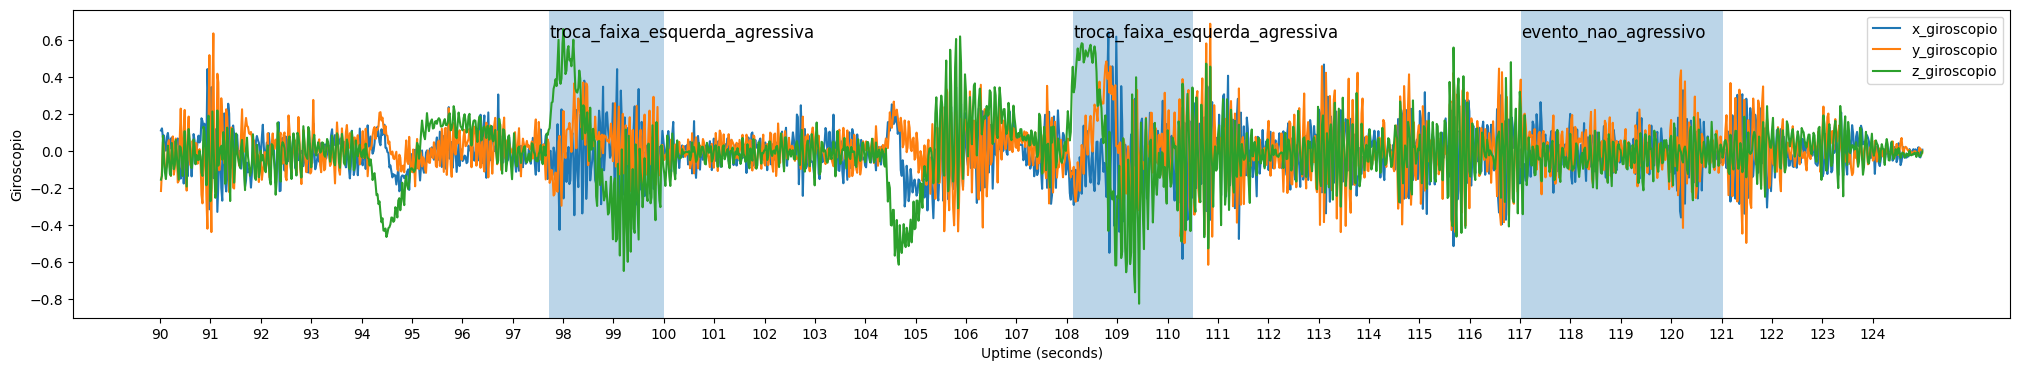

In [8]:
plot_sensor_data(df_21, 'giroscopio', figsize=(25, 4), begin=90, end=125)

# Machine Learning Algorithm

First, let's try directly applying a RF algorithm using a single drive to see what happens

In [161]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Using sliding windows to allow for classification

Ignorar o tempo na hora do treinamento, basicamente gerar as janelas pra cada sequência de forma que uma janela nunca tenha mais de uma sequência

In [123]:
def create_sliding_windows(data, window_size=100, overlap=0.5):
    X = []
    y = []
    for i in range(0, len(data) - window_size + 1, int(window_size*overlap)):
        end = i + window_size
        window = data[i:end].drop(['evento', 'seconds_passed'], axis=1, inplace=False) # Dropping 'evento' and 'seconds_passed' columns
        window_label = data['evento'][i:end].value_counts().index.to_list()[0] # Getting the most frequent event in the window
        X.append(window) 
        y.append(window_label)
    return np.array(X), np.array(y)

In [165]:
cols = ['timestamp', 'uptimeNanos']
data = df_16.drop(cols, axis=1, inplace=False)

In [166]:
X, y = create_sliding_windows(data, window_size=100, overlap=0.5) # This will create the sliding windows with a 3D X and 1D y
X.shape, y.shape

((1291, 100, 9), (1291,))

In [155]:
# Reshaping X to be used in the classifier, we need an array of shape (n_samples, n_features * window_size)
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2]) # This will flatten the array to be used in the classifier
X.shape

(1291, 900)

Splitting without losing the time property

In [156]:
trainset_size = 0.8
split = int(len(X) * trainset_size)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Verifying the balance of the split

In [192]:
def get_unique_counts(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

In [194]:
print('Train set:', get_unique_counts(y_train))
print('Test set:', get_unique_counts(y_test))

Train set: {'curva_direita_agressiva': 16, 'curva_esquerda_agressiva': 14, 'evento_nao_agressivo': 12, 'sem_evento': 990}
Test set: {'curva_esquerda_agressiva': 4, 'sem_evento': 249, 'troca_faixa_direita_agressiva': 6}


Creating and training the classifier

In [158]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [159]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [162]:
y_pred = clf.predict(X_test)
print(f"Classification report:\n{classification_report(y_test, y_pred)}")

Classification report:
                               precision    recall  f1-score   support

     curva_esquerda_agressiva       1.00      0.75      0.86         4
                   sem_evento       0.97      1.00      0.99       249
troca_faixa_direita_agressiva       0.00      0.00      0.00         6

                     accuracy                           0.97       259
                    macro avg       0.66      0.58      0.61       259
                 weighted avg       0.95      0.97      0.96       259



/home/renan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NameError: name 'classification_report' is not defined